# LangGraph Advanced with Llama 3

Will apply [Llama 3 (8B Model)](https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3) through [Ollama](https://python.langchain.com/docs/integrations/chat/ollama/) to build [LangGraph](https://python.langchain.com/docs/langgraph/) multi-agent RAG Sytems

Ensure that you have `Ollama` running and have pulled `Llama3:8B` model 

In [76]:
import os
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import YoutubeLoader
from langchain_community.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain_openai import OpenAIEmbeddings
from langchain_community.retrievers import TavilySearchAPIRetriever
from typing_extensions import TypedDict
from typing import Dict, List
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.vectorstores import VectorStoreRetriever
from langchain_community.docstore.document import Document
from langgraph.graph import END, StateGraph
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML
import base64
import nest_asyncio
from pprint import pprint

Inspiration from [Langchain Videos](https://www.youtube.com/watch?v=-ROS6gfYIts) and [previous notebook](https://github.com/jzamalloa1/langchain_learning/blob/main/langgraph_testing.ipynb)

<p>
<img src="ILLUSTRATIONS/langgraph_advanced_flow.png" 
      width="65%" height="auto"
      style="display: block; margin: 0 auto" />

Illustration [reference](https://github.com/jzamalloa1/langchain_learning/blob/main/langgraph_testing.ipynb)

In [4]:
# OpenAI API Key solely to use embedding model
os.environ["OPENAI_API_KEY"] = ""
os.environ["TAVILY_API_KEY"] = ""

In [5]:
llama_model = "llama3:8b"

#### Source for Vector Stores

In [6]:
llm_urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
    
]

plotly_yt_urls = [
    "https://www.youtube.com/watch?v=Qx5eFVUdDxk&list=PLYD54mj9I2JevdabetHsJ3RLCeMyBNKYV&index=1",
    "https://www.youtube.com/watch?v=Z9YUejzkFa0&list=PLYD54mj9I2JevdabetHsJ3RLCeMyBNKYV&index=2",
    "https://www.youtube.com/watch?v=4bP66rRxVBw&list=PLYD54mj9I2JevdabetHsJ3RLCeMyBNKYV&index=3",
    "https://www.youtube.com/watch?v=a1qzu5GKIf0&list=PLYD54mj9I2JevdabetHsJ3RLCeMyBNKYV&index=4",
    "https://www.youtube.com/watch?v=Fm7DC-Z5R7A&list=PLYD54mj9I2JevdabetHsJ3RLCeMyBNKYV&index=5",
    "https://www.youtube.com/watch?v=4jcWJ30HqSY&list=PLYD54mj9I2JevdabetHsJ3RLCeMyBNKYV&index=6"
]

#### Build Retrievers - One for LLM docs and one for Plotly docs

In [7]:
#### LLM DOCS VECTOR STORE #####
llm_docs = [WebBaseLoader(url).load() for url in llm_urls] # Each loader produced a list of one element
llm_docs = [i for j in llm_docs for i in j] # Decoupling lists of one element

text_splitter_class = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

chunks = text_splitter_class.split_documents(llm_docs)
print(f"Split into {len(chunks)} chunks")

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

llm_llw_vectorstore = Chroma.from_documents(
    documents = chunks,
    embedding = embedding_model,
    collection_name = "chroma_llm_llw"
)

llm_llw_retriever = llm_llw_vectorstore.as_retriever()


#### YOUTUBE PLOTLY VECTOR STORE #####
yt_docs = [YoutubeLoader.from_youtube_url(url, add_video_info=False).load() for url in plotly_yt_urls] # Each loader produced a list of one element
yt_docs = [i for j in yt_docs for i in j] # Decoupling lists of one element

text_splitter_class = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

chunks = text_splitter_class.split_documents(yt_docs)
print(f"Split into {len(chunks)} chunks")

plotly_yt_vectorstore = Chroma.from_documents(
    documents = chunks,
    embedding = embedding_model,
    collection_name = "chroma_plotly_yt"
)

plotly_yt_retriever = plotly_yt_vectorstore.as_retriever()

Split into 194 chunks
Split into 109 chunks


In [8]:
print(type(llm_llw_retriever))
print(type(plotly_yt_retriever))

<class 'langchain_core.vectorstores.VectorStoreRetriever'>
<class 'langchain_core.vectorstores.VectorStoreRetriever'>


#### Build Routers function for Conditional Graph node

**Ollama** has `format="json"`. This ensures output from llm is a JSON. Recall that in the [ChatOpenAI implementation](https://github.com/jzamalloa1/langchain_learning/blob/main/langgraph_testing.ipynb) we tested before we had to create a pydantic object and bind it to our ChatOpenAI llm to ensure structured output. We don't have to do that here.

Note: One way that we could have addressed that could have been by adding `model_kwargs={"response_format":{"type":"json_object"}}` to **ChatOpenAI**, but not sure if this works 100% (or perhaps does work as well as Ollama's json mode)

In [24]:
#### FIRST ROUTER TO DECIDE IF WE SHOULD USE WEB SEARCH OR INTERNAL VECTOR STORES #####
llm = ChatOllama(model=llama_model, format="json", temperature=0,
                 callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]))

prompt = PromptTemplate(
    template="""
    <|begin_of_text|>
    <|start_header_id|>system<|end_header_id|> 
    You are an expert at routing a user question to a vectorstore or web search. 
    Use the vectorstore for questions on LLM  agents, 
    prompt engineering, adversarial attacks and developing charts with Plotly. 
    You do not need to be stringent with the keywords in the question related to these topics. 
    Otherwise, use web-search. Give a binary choice 'web_search' 
    or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and 
    no preamble or explanation. 
    Question to route: {question} <|eot_id|>
    
    <|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question"],
)

initial_router_chain = prompt | llm | JsonOutputParser()

initial_router_chain.invoke({"question":"How can I build a histogram using plotly?"})

{"datasource": "vectorstore"} 

  



 






 






 






 






 






 






 






 






 






 






 






 






 






 








{'datasource': 'vectorstore'}

In [25]:
#### SECOND ROUTER (IF VECTORSTORE IS CHOSEN) TO DECIDE IF WE SHOULD USE THE LLM OR THE PLOTLY RETRIEVER #####
llm = ChatOllama(model=llama_model, format="json", temperature=0,
                 callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]))

prompt = PromptTemplate(
    template="""
    <|begin_of_text|>
    <|start_header_id|>system<|end_header_id|> 
    You are an expert at routing a user question to an LLM documentation vectorstore or a Plotly vectorstore. 
    Use the LLM vectorstore for questions on LLM  agents, 
    prompt engineering and adversarial attacks. 
    You do not need to be stringent with the keywords in the question related to these topics. 
    Otherwise, use the plotly vectorstore for things like Plotly charts. Give a binary choice 'llm_agent' 
    or 'plotly' based on the question. Return the a JSON with a single key 'datasource' and 
    no preamble or explanation. 
    Question to route: {question} <|eot_id|>
    
    <|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question"],
)

vector_router_chain = prompt | llm | JsonOutputParser()

vector_router_chain.invoke({"question":"what are adversarial agents?"})

{"datasource": "llm_agent"} 

  																			   																			   																			   																			   																			   																			   																			   

{'datasource': 'llm_agent'}

#### Build Retrieval Grader

In [78]:
# Retrieval Grader
llm = ChatOllama(model=llama_model, format="json", temperature=0,
                 callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]))

prompt = PromptTemplate(
    template="""
    <|begin_of_text|>
    <|start_header_id|>system<|end_header_id|>
    You are a grader assessing relevance of a retrieved document to a user question. 
    If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    <|eot_id|>
    
    <|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|>
    
    <|start_header_id|>assistant<|end_header_id|>
    """,

    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "langchain memory use"
docs = llm_llw_retriever.invoke(question)
doc_txt = docs[1].page_content

grader_output = retrieval_grader.invoke({"question": question, "document": doc_txt})


{"score": "yes"} 

    



    



    



    



    



    



    



    



    



    



    



    



    



    



    





In [81]:
print(type(grader_output))
print(grader_output)
print(grader_output["score"])

<class 'dict'>
{'score': 'yes'}
yes


#### Build Retrieval Generator

In [12]:
# LLM (Without json mode since we want inference text)
llm = ChatOllama(model=llama_model, temperature=0,
                 callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]))

# Prompt
prompt = PromptTemplate(
    template="""
    <|begin_of_text|>
    <|start_header_id|>system<|end_header_id|> 
    You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. 
    Keep the answer concise and to the point. <|eot_id|>
    
    <|start_header_id|>user<|end_header_id|>
    Question: {question} 
    Context: {context} 
    Answer: <|eot_id|>
    
    <|start_header_id|>assistant<|end_header_id|>""",
    
    input_variables=["question", "document"],
)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

In [13]:
# Example run
question = "how can I create a lineplot?"
docs = plotly_yt_retriever.invoke(question)
rag_chain.invoke({"context":format_docs(docs), "question":question})

To create a lineplot, you can use Plotly Express in Dash. Here's an example:

```
import plotly.express as px
import pandas as pd

# Create a sample dataset
df = pd.DataFrame({
    'Year': [2015, 2016, 2017, 2018, 2019],
    'Value': [10, 20, 30, 40, 50]
})

# Create the lineplot
fig = px.line(df, x='Year', y='Value')

# Update the figure reference
fig.update_layout(title='Lineplot Example')
```

In this example, we create a sample dataset using Pandas, and then use Plotly Express to create a lineplot. The `px.line()` function takes in the dataset and specifies the x-axis (`'Year'`) and y-axis (`'Value'`) columns.

You can customize your lineplot by adding more attributes, such as colors, markers, and ranges. For example, you can add a color attribute to differentiate between different lines:

```
fig = px.line(df, x='Year', y='Value', color='Value')
```

This will create a lineplot with different colors for each year's data point.

You can also use the `range` attribute to limit the r

"To create a lineplot, you can use Plotly Express in Dash. Here's an example:\n\n```\nimport plotly.express as px\nimport pandas as pd\n\n# Create a sample dataset\ndf = pd.DataFrame({\n    'Year': [2015, 2016, 2017, 2018, 2019],\n    'Value': [10, 20, 30, 40, 50]\n})\n\n# Create the lineplot\nfig = px.line(df, x='Year', y='Value')\n\n# Update the figure reference\nfig.update_layout(title='Lineplot Example')\n```\n\nIn this example, we create a sample dataset using Pandas, and then use Plotly Express to create a lineplot. The `px.line()` function takes in the dataset and specifies the x-axis (`'Year'`) and y-axis (`'Value'`) columns.\n\nYou can customize your lineplot by adding more attributes, such as colors, markers, and ranges. For example, you can add a color attribute to differentiate between different lines:\n\n```\nfig = px.line(df, x='Year', y='Value', color='Value')\n```\n\nThis will create a lineplot with different colors for each year's data point.\n\nYou can also use the `r

Does the code actually work?? - A simple plot does work

In [17]:
import plotly.express as px
import pandas as pd

# Create a sample dataset
df = pd.DataFrame({
    'Year': [2015, 2016, 2017, 2018, 2019],
    'Value': [10, 20, 30, 40, 50]
})

# Create the lineplot
fig = px.line(df, x='Year', y='Value')
# fig = px.line(df, x='Year', y='Value', color='Value')

# Update the figure reference
fig.update_layout(title='Lineplot Example')

In [18]:
# Example run with unrelated question, info not found in vector store
question = "what is the One Piece?"
docs = plotly_yt_retriever.invoke(question)
rag_chain.invoke({"context":format_docs(docs), "question":question})

I don't know what the One Piece is. The context provided appears to be about a course on Plotly and Dash, but it doesn't mention anything related to "One Piece".

'I don\'t know what the One Piece is. The context provided appears to be about a course on Plotly and Dash, but it doesn\'t mention anything related to "One Piece".'

#### Build Websearch Tool

In [19]:
web_tool = TavilySearchAPIRetriever(k=5)

In [20]:
web_tool.invoke("A que equipo derrotaron Los Chankas el fin de semana pasado?")

[Document(page_content='El conjunto de Andahuaylas cuenta hasta el momento con el 50% de los puntos que se pusieron en juego. En casa derrotó a Unión Comercio, ADT y en la pasada fecha a Sport Boys (2-0).', metadata={'title': 'Goles, Mannucci vs. Los Chankas: ver 2-1, resumen y VIDEO del partido ...', 'source': 'https://rpp.pe/futbol/descentralizado/mannucci-vs-los-chankas-en-vivo-golperu-ver-liga-1-2024-online-link-gratis-apertura-fecha-7-trujillo-noticia-1539796', 'score': 0.97491, 'images': None}),
 Document(page_content='Visita ESPN DEPORTES y disfruta de resultados en vivo, highlights y las últimas noticias de Los Chankas. Conoce la tabla de posiciones y el calendario completo de la temporada 2024.', metadata={'title': 'Los Chankas Resultados, estadísticas y highlights - ESPN Deportes', 'source': 'https://espndeportes.espn.com/futbol/equipo/_/id/22168', 'score': 0.95997, 'images': None}),
 Document(page_content='Los Chankas derrotaron 2-0 a Santos FC en el cierre del Torneo Apertu

#### Build Answer Grader

In [21]:
llm = ChatOllama(model=llama_model, format="json", temperature=0,
                 callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]))

# Prompt
prompt = PromptTemplate(
    template="""
    <|begin_of_text|>
    <|start_header_id|>system<|end_header_id|> 
    You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|>
     
     <|start_header_id|>user<|end_header_id|> 
     Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: 
    {question} 
    <|eot_id|>
    
    <|start_header_id|>assistant<|end_header_id|>""",

    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()

In [22]:
# Test answer grader
answer_grader.invoke({"question": "How do we build graphs in plotly?",
                      "generation": "The One Piece is the best manga in the world"})

{"score": "no"} 






    



  





  





  





  





  





  





  





  





  







{'score': 'no'}

#### Build Query Improve (Re-generate query)

In [56]:
# LLM (Without json mode since we want inference text)
llm = ChatOllama(model=llama_model, temperature=0,
                 callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]))

prompt = PromptTemplate(
    template="""
    <|begin_of_text|>
    <|start_header_id|>system<|end_header_id|> 
    You are question re-writer that converts an input question to a better 
    version that is optimized for vectorstore retrieval.
    Look at the input and try to reason about the underlying 
    semantic intent / meaning and re-write it.
    Don't provide a preamble.
    <|eot_id|>
    
    <|start_header_id|>user<|end_header_id|>
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    <|eot_id|>
    
    <|start_header_id|>assistant<|end_header_id|>""",
    
    input_variables=["question"],
)

re_write_chain = prompt | llm | StrOutputParser()

# Improve query example
question = "what is the write way to use plotly to define line charts?"
improved_question = re_write_chain.invoke({"question":question})

How can I effectively utilize Plotly to create well-structured and informative line charts, considering various visualization options and customization possibilities?

### Build Graph - Initialize

In [26]:
class GraphState(TypedDict):
    
    question: str
    generation: str
    docs: List[str]
    run_web_search: str
    retriever: VectorStoreRetriever

### Build Graph - Define Nodes and Edges

In [82]:
##### NODES #####

# RETRIEVER SELECTOR NODE - WILL RETURN APPROPRIATE RETRIEVER BASED ON VECTOR_ROUTER OUTPUT
def retriever_selector(state): 

    """
    Selects retriever to be used from either plotly or llm agent vector store retrievers based on vector_router llm output
    """

    print("---VECTOR STORE SOURCE ROUTER---")

    question = state["question"]
    vector_source_response = vector_router_chain.invoke({"question":question})

    if vector_source_response["datasource"] == "llm_agent":
        print("---VECTOR ROUTING TO: LLM AGENT DOCS---")
        # return "llm_agent_vdb"
        db_retriever =llm_llw_retriever

    elif vector_source_response["datasource"] == "plotly":
        print("---INITIAL ROUTE TO: PLOTLY DOCS---")
        db_retriever =plotly_yt_retriever
    
    # Return updated state with selected retriever
    return {"question":question, "retriever":db_retriever}
    
# RETRIEVER NODE
def retrieve(state):

    print("---RETRIEVE---")

    # Get a question from the state dictionary
    question = state["question"]
    retriever = state["retriever"] # Of class VectorStoreRetriever (either llm_llw_retriever or plotly_yt_retriever in our case)

    # Execute retriever to get documents
    docs = retriever.get_relevant_documents(question)

    # Return to write back (update) state
    return {"docs":docs, "question":question}

# GENERATE NODE
def generate(state):

    print("---GENERATE---")

    # Get question from dictionary
    question = state["question"]

    # Get documents stored in update state (theoretically retrieved using retriever)
    docs = state["docs"]

    # Generate
    generation = rag_chain.invoke({"context":format_docs(docs), "question":question})

    # Return generation to update state
    return {"docs":docs, "question":question, "generation":generation}

# GRADING DOCUMENTS NODE
def grading_docs(state):

    print("---GRADE DOCS WITH REGARDS TO QUESTION---")

    question = state["question"]
    docs = state["docs"]

    # Grade retrieved docs with grader_chain AND add `web_search` if at least one document irrelevant
    filtered_docs = []
    run_web_search = "no" # Start variable as "no" and change only if we get a single irrelevant document
    for i in docs:
        score = retrieval_grader.invoke({"question":question, "document":i.page_content})
                
        grade = score["score"]

        if grade.lower() == "yes":
            print("---Doc is relevant---")
            filtered_docs.append(i)
        else:
            print("---Doc is not relevant")
            run_web_search = "yes" # WILL PERFORM WEB SEARCH if we have an irrelevant document
            continue
    
    # Update state with filtered docs
    return {"docs": filtered_docs, "question":question, "run_web_search":run_web_search}

# IMPROVE QUERY NODE
def improve_query(state):
    """
    Improve query being asked by re-generating it with an LLM
    """

    print("---IMPROVE QUERY---")

    question  = state["question"]
    docs = state["docs"]

    # Improve query
    improved_question = re_write_chain.invoke({"question":question})

    # Update state with improved question
    return {"docs": docs, "question":improved_question}


# WEB SEARCH NODE - REVISE!!! EITHER IF WEB SEARCH DUE TO INITIAL ROUTING OR WEB SEARCH BECAUSE OF YES IN GRADER. THIS AFFECT DOCS FED AND EXTEND!
def web_search(state):

    """
    Web search using query to retrieve relevant docs
    """

    print("---WEB SEARCH FOR DOCS---")

    question = state["question"]
    docs = state["docs"] # MAY NOT HAVE DOCS AT FIRST, NEED TO PROBABLY INITIALY WITH NONE!!!

    # Retrieve relevant web documents
    web_results = web_tool.invoke(question)
    web_docs = [Document(page_content = i.page_content) for i in web_results]

    if docs is not None: # DOES NOT HAVE DOCS ON INITIAL ROUTER!!
        # Add to running document list
        docs.extend(web_docs)

    else: #PROBABLY WHAT HAPPENS ON INITIAL ROUTING
        docs = web_docs

    # Return updated document list into state
    return {"docs":docs, "question":question}


###### CONDITIONAL EDGES #######

# INITIAL ROUTING EDGE

def initial_router(state):

    """
    Routes query to web search or vector database
    """

    print("---INITIAL ROUTER----")

    question = state["question"]
    source_choice_response = initial_router_chain.invoke({"question":question})

    if source_choice_response["datasource"] == "web_search":
        print("---INITIAL ROUTE TO: WEB SEARCH---")
        return "websearch"

    elif source_choice_response["datasource"] == "vectorstore":
        print("---INITIAL ROUTE TO: VECTOR STORE---")
        return "vectorstore"

def retrieved_decission_maker_with_web_search(state):
    """
    Will decide to re-formulate query + pass that to web search if at least
    one retrieved document was found to be non-relevant
    """

    print("---COND EDGE: ASSESS IF NEEDS TO RE-GENERATE QUERY AND ADD WEB SEARCH RESULTS OR NO WEB SEARCH NEEDED---")

    question = state["question"]
    filtered_docs = state["docs"]
    run_web_search = state["run_web_search"]

    if run_web_search=="yes":
        print("---FOUND AT LEAST ONE DOC IRRELEVANT: WILL IMPROVE QUERY AND RUN WEB SEARCH TO RETRIEVE ADDITIONAL RELEVANT DOCS")
        return "improve_query"
    else:
        print("---ALL DOCS FOUNDS TO BE RELEVANT: NO NEED TO RUN WEB SEARCH, WILL GO AHEAD AND GENERATE ANSWER---")
        return "generate"


### Build Graph - Define Structure

Notice how we use `set_conditional_entry_point` instead of `set_entry_point` since we are using a conditional edge on entry

In [83]:
workflow = StateGraph(GraphState)

workflow.add_node("retriever_selector", retriever_selector)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)
workflow.add_node("grading_docs", grading_docs)
workflow.add_node("improve_query", improve_query)
workflow.add_node("websearch", web_search) # Notice key_name versus function being called

workflow.set_conditional_entry_point( 
    initial_router,
    {
        "websearch":"websearch", # Notice key_name used as decision output and second argument is the node to follow
        "vectorstore":"retriever_selector" # More visible here, first argument is output of "initial_router", and second argument is decision node/edge
    }
)

# RETRIEVE_SELECTOR PATH (INTERNAL VECTOR DB)
workflow.add_edge("retriever_selector", "retrieve")
workflow.add_edge("retrieve", "grading_docs")
workflow.add_conditional_edges(
    "grading_docs", # Source node
    retrieved_decission_maker_with_web_search, # End node, notice how end node in conditional edges are the actual function variables
    {
        "improve_query":"improve_query", # If conditional edge output is "improve_query", then "improve_query" node will be called
        "generate":"generate" # If conditional edge output is "generate", then "generate" node will be called
    }
    
)
workflow.add_edge("improve_query", "websearch")
workflow.add_edge("websearch", "generate")

# WEB_SEARCH PATH (EXTERNAL WEB NON-VECTOR DB)
# workflow.add_edge("websearch", "....") # NEED TO MODIFY!!

# ENDING EDGE WITH GENERATION
workflow.add_edge("generate", END)

### Compile Graph and visualize Graph Structure

In [84]:
multi_agent_app = workflow.compile()

In [63]:
multi_agent_app.get_graph().print_ascii()

                                     +-----------+                       
                                     | __start__ |                       
                                     +-----------+                       
                                           *                             
                                           *                             
                                           *                             
                                  +----------------+                     
                                  | initial_router |                     
                                  +----------------+...                  
                                ...                    .....             
                            ....                            ....         
                          ..                                    ....     
            +--------------------+                                  ...  
            | retriever_selector |    


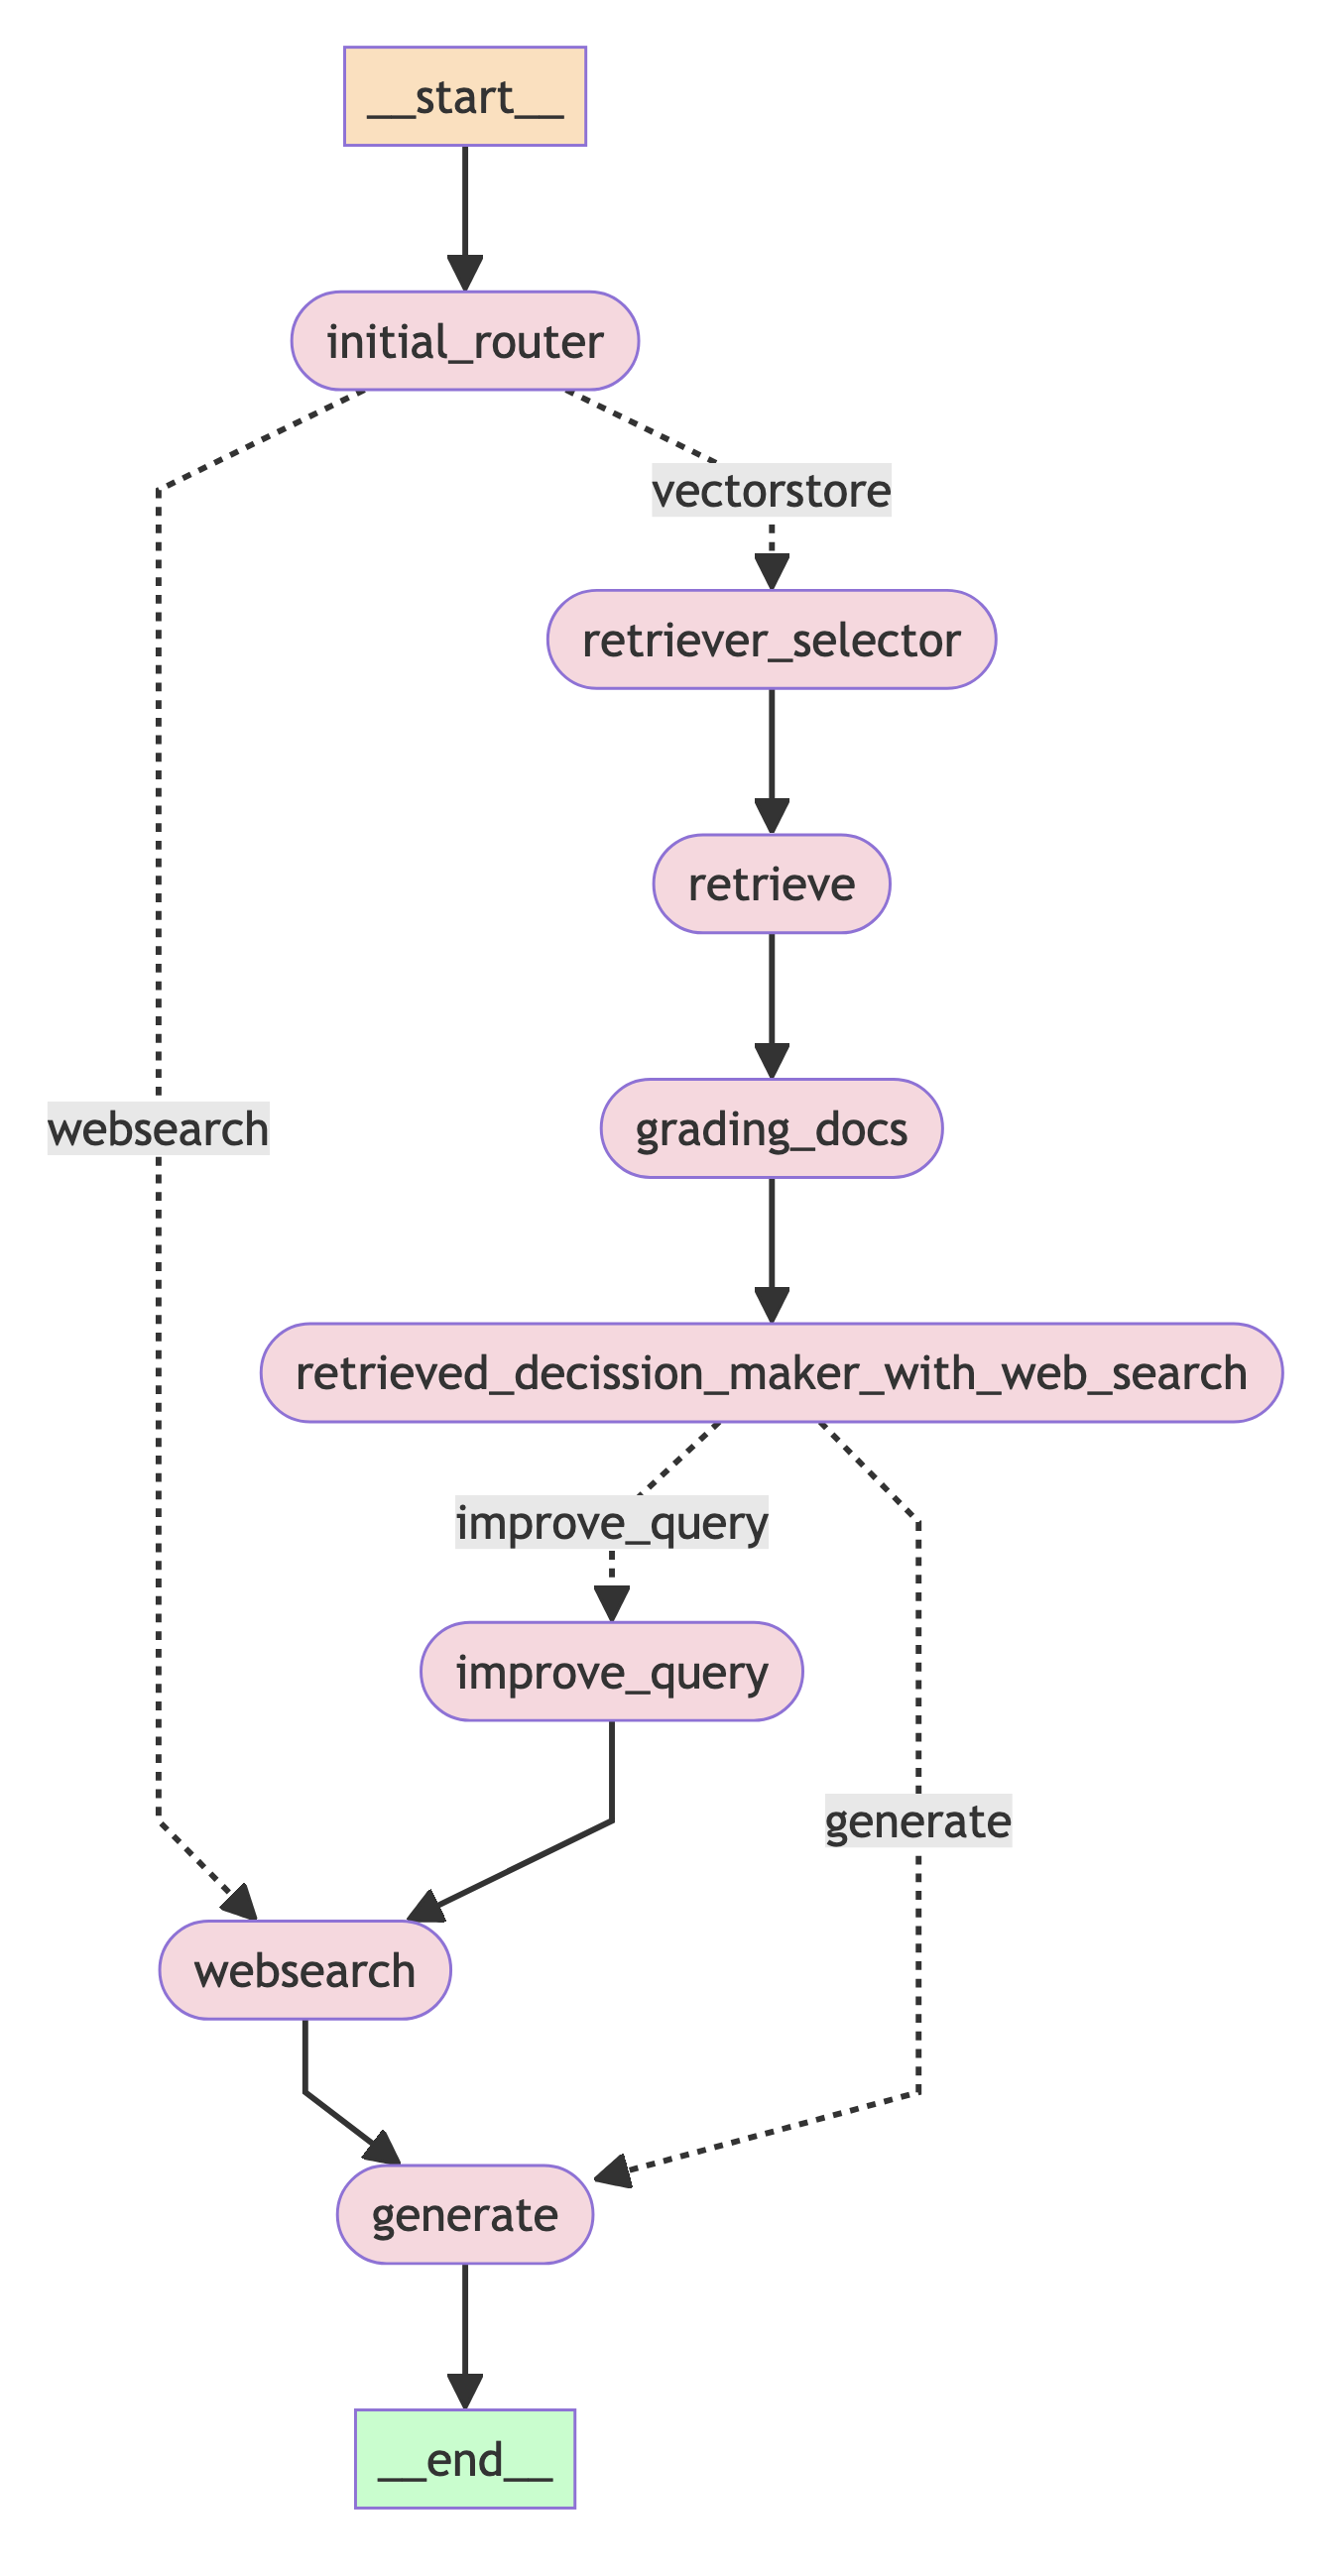

In [75]:
nest_asyncio.apply() # Required for Jupyter Notebook to run async functions

def display_image(image_bytes: bytes, width=500):
    decoded_img_bytes = base64.b64encode(image_bytes).decode('utf-8')
    html = f'<img src="data:image/png;base64,{decoded_img_bytes}" style="width: {width}px;" />'
    display(HTML(html))

display_image(multi_agent_app.get_graph().draw_mermaid_png(
    curve_style=CurveStyle.LINEAR,
    node_colors=NodeColors(start="#ffdfba", end="#baffc9", other="#fad7de"),
    wrap_label_n_words=9,
    output_file_path=None,
    draw_method=MermaidDrawMethod.PYPPETEER,
    background_color="white",
    padding=10
))

### Finally, Run Graph Multi-Agent with query of interest

In [85]:
# Run
inputs = {"question": "Explain how one can use plotly to generate histograms?"}
for output in multi_agent_app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---INITIAL ROUTER----
{"datasource": "vectorstore"} 

  



 






 






 






 






 






 






 






 






 






 






 






 






 






 






---INITIAL ROUTE TO: VECTOR STORE---
---VECTOR STORE SOURCE ROUTER---
{"datasource": "plotly"} 

    



    



    



    



    



    



    



    



    



    



    



    



    



    



    



---INITIAL ROUTE TO: PLOTLY DOCS---
"Node 'retriever_selector':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---GRADE DOCS WITH REGARDS TO QUESTION---
{"score": "yes"} 

  





  





  





  





  





  





  





  





  





  





---Doc is relevant---
{"score": "yes"} 

 





 





 





 





 





 





 





 





 





 





 





 





 





 





 





---Doc is relevant---
{"score": "yes"} 

  





  





  





  





  





  





  





  





  





  





---Doc is relevant---
{"score": "yes"} 

 





 





 





 





 





 





 

In [86]:
# Run
inputs = {"question": "What is the One Piece, and why are there so many fans interested in it?"}
for output in multi_agent_app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---INITIAL ROUTER----
{"datasource": "web_search"} 

    



    



    



    



    



    



    



    



    



    



    



    



    



    



    



---INITIAL ROUTE TO: WEB SEARCH---
---WEB SEARCH FOR DOCS---
"Node 'websearch':"
'\n---\n'
---GENERATE---
The One Piece is a mythical treasure that serves as the central plot point in the story, with Monkey D. Luffy's quest to find and claim it as his goal.

As for why there are so many fans interested in it, One Piece has become a fan favorite due to its engaging storyline, memorable characters, and impressive animation sequences. The series has broken numerous records, including sales and audience demand, making it one of the most popular manga and anime series of all time."Node 'generate':"
'\n---\n'
('The One Piece is a mythical treasure that serves as the central plot point '
 "in the story, with Monkey D. Luffy's quest to find and claim it as his "
 'goal.\n'
 '\n'
 'As for why there are so many fans intereste